## Imports des bibliothèques nécessaires

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Outils de validation / découpage de scikit-learn
from sklearn.model_selection import (
    train_test_split,     # découpage hold-out train / test
    StratifiedKFold,      # K-fold en respectant les proportions de classes
    cross_val_predict     # prédictions en validation croisée (toutes les obs.)
)

# Prétraitement : standardisation des variables explicatives
from sklearn.preprocessing import StandardScaler

# Pipeline : chaîner prétraitement + modèle dans un seul objet
from sklearn.pipeline import Pipeline

# Classifieurs linéaires vus en cours :
from sklearn.linear_model import Perceptron, LogisticRegression  # perceptron + régression logistique
from sklearn.svm import LinearSVC                               # SVM linéaire (hyperplan à large marge)

# Réseau de neurones (perceptron multicouche / MLP)
from sklearn.neural_network import MLPClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    accuracy_score,             # probabilité de classification correcte (P_test dans le cours)
    classification_report,      # précision / rappel / F1 par classe
    confusion_matrix,           # matrice de confusion numérique
    ConfusionMatrixDisplay      # outil pratique pour tracer la matrice de confusion
)

## Chargement des données et découpage hold-out

### Chargement du fichier de données nettoyées (préparé dans le notebook d'EDA)

In [4]:
df = pd.read_csv("../data/data_clean.csv")

# Suppression éventuelle d'une colonne d'index technique qui ne doit pas être utilisée comme feature
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

# Séparation entre X : matrice des variables explicatives (toutes les colonnes sauf 'diagnosis'), et y : vecteur des étiquettes (diagnostic 0/1)
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# Découpage hold-out : 80 % des données pour l'entraînement, 20 % pour le test
# On stratifie sur y pour conserver la proportion bénin/malin dans les deux sous-échantillons
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # environ 20 % pour l'ensemble de test
    random_state=0,      # graine pour rendre le découpage reproductible
    stratify=y           # stratification sur la variable cible
)

print("Nombre total d'exemples :", X.shape[0])
print("Taille ensemble d'entraînement :", X_train.shape[0])
print("Taille ensemble de test        :", X_test.shape[0])

Nombre total d'exemples : 569
Taille ensemble d'entraînement : 455
Taille ensemble de test        : 114


## Fonction utilitaire pour analyser la matrice de confusion

In [5]:
def decrire_matrice_confusion(cm, labels):
    """
    Prend une matrice de confusion 2x2 et affiche pour chaque classe :
      - vrais positifs (VP)
      - faux positifs (FP)
      - faux négatifs (FN)
      - vrais négatifs (VN)
    L'ordre des labels doit correspondre à l'ordre utilisé dans confusion_matrix.
    """

    # On suppose un problème binaire avec labels = [0, 1]
    # cm[i, j] = nombre d'exemples de classe vraie i prédits comme j
    tn = cm[0, 0]  # vrai négatif  : vrai 0, prédit 0  (tumeur bénigne bien classée)
    fp = cm[0, 1]  # faux positif  : vrai 0, prédit 1  (bénigne prédite maligne)
    fn = cm[1, 0]  # faux négatif  : vrai 1, prédit 0  (maligne prédite bénigne)
    tp = cm[1, 1]  # vrai positif  : vrai 1, prédit 1  (tumeur maligne bien classée)

    print(f"\nDétail de la matrice de confusion (ordre des classes : {labels})")
    print("------------------------------------------------------------")
    print(f"Vrais négatifs  (TN) : {tn}  -> tumeurs bénignes correctement détectées")
    print(f"Faux positifs   (FP) : {fp}  -> tumeurs bénignes prédites malignes")
    print(f"Faux négatifs   (FN) : {fn}  -> tumeurs malignes prédites bénignes")
    print(f"Vrais positifs  (TP) : {tp}  -> tumeurs malignes correctement détectées")

    # Calcul du nombre total de faux positifs / faux négatifs
    total_fp = fp
    total_fn = fn

    print("\nRésumé des erreurs :")
    print(f"  - Nombre total de faux positifs  : {total_fp}")
    print(f"  - Nombre total de faux négatifs  : {total_fn}")

    # Selon le contexte médical, les faux négatifs sont les plus graves (cancer non détecté)
    if total_fn > total_fp:
        print("  -> Le modèle commet davantage de faux négatifs que de faux positifs.")
    elif total_fn < total_fp:
        print("  -> Le modèle commet davantage de faux positifs que de faux négatifs.")
    else:
        print("  -> Le modèle commet autant de faux positifs que de faux négatifs.")

## Fonctions d’évaluation (hold-out + validation croisée)

In [6]:
# Fonctions d'évaluation (hold-out et CV k-fold)

def eval_holdout(model, model_name, X_train, X_test, y_train, y_test):
    """
    Entraîne un modèle sur l'ensemble d'entraînement (stratégie hold-out)
    puis l'évalue sur l'ensemble de test.

    Affiche :
      - l'accuracy (taux de bonnes classifications)
      - le taux d'erreur (= 1 - accuracy)
      - le rapport de classification
      - la matrice de confusion + son interprétation (FP / FN)
    Retourne un dictionnaire avec les métriques principales.
    """

    print(f"\n================= {model_name} — Stratégie hold-out =================")

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions du modèle sur les données de test
    y_pred = model.predict(X_test)

    # Taux de bonnes classifications (accuracy au sens du cours P_test)
    acc = accuracy_score(y_test, y_pred)
    err = 1.0 - acc   # taux d'erreur empiriquement estimé sur le test

    print(f"\nAccuracy (test)      : {acc:.4f}")
    print(f"Taux d'erreur (test) : {err:.4f}\n")

    # Rapport détaillé : précision, rappel, F1 par classe
    print("Rapport de classification (test) :")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["Bénigne (0)", "Maligne (1)"]
    ))

    # Matrice de confusion (ordre des labels fixé : 0 puis 1)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    print("Matrice de confusion (test) :")
    print(cm)

    # Détail des faux positifs / faux négatifs
    decrire_matrice_confusion(cm, labels=[0, 1])

    # Affichage graphique de la matrice de confusion
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Bénigne (0)", "Maligne (1)"]
    )
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format="d")
    plt.title(f"Matrice de confusion — {model_name} (hold-out)")
    plt.show()

    # Renvoi des métriques principales pour le tableau récapitulatif
    return {
        "modèle": model_name,
        "stratégie": "hold-out",
        "accuracy": acc,
        "erreur": err
    }


def eval_cv(model, model_name, X, y, cv_splits=5):
    """
    Évalue un modèle en validation croisée stratifiée k-fold.

    Utilise cross_val_predict pour obtenir, pour chaque observation,
    une prédiction issue d'un modèle entraîné sans cette observation.
    On peut ainsi construire :
      - une matrice de confusion globale (en cumulant tous les plis)
      - une accuracy globale (proportion d'exemples bien classés)

    Retourne un dictionnaire avec les métriques principales.
    """

    print(f"\n================= {model_name} — VALIDATION CROISÉE {cv_splits}-fold =================")

    # Définition de la stratégie de validation croisée (stratifiée)
    cv = StratifiedKFold(
        n_splits=cv_splits,   # nombre de plis k
        shuffle=True,         # on mélange avant de découper
        random_state=0        # graine pour reproductibilité
    )

    # cross_val_predict renvoie, pour chaque exemple, la prédiction obtenue
    # quand cet exemple se trouve dans le pli de test (jamais dans le train)
    y_pred_cv = cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=-1             # parallélisation si possible
    )

    # Accuracy globale (équivalent à la moyenne des accuracies sur les k plis,
    # tous les plis ayant pratiquement la même taille)
    acc_cv = accuracy_score(y, y_pred_cv)
    err_cv = 1.0 - acc_cv

    print(f"\nAccuracy (CV {cv_splits}-fold)      : {acc_cv:.4f}")
    print(f"Taux d'erreur (CV {cv_splits}-fold) : {err_cv:.4f}\n")

    # Rapport de classification global (toutes les prédictions cumulées)
    print("Rapport de classification (validation croisée) :")
    print(classification_report(
        y,
        y_pred_cv,
        target_names=["Bénigne (0)", "Maligne (1)"]
    ))

    # Matrice de confusion globale (en cumulant tous les plis)
    cm_cv = confusion_matrix(y, y_pred_cv, labels=[0, 1])

    print("Matrice de confusion globale (CV) :")
    print(cm_cv)

    # Détail des faux positifs / faux négatifs
    decrire_matrice_confusion(cm_cv, labels=[0, 1])

    # Affichage graphique de la matrice de confusion globale
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_cv,
        display_labels=["Bénigne (0)", "Maligne (1)"]
    )
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format="d")
    plt.title(f"Matrice de confusion — {model_name} (CV {cv_splits}-fold)")
    plt.show()

    return {
        "modèle": model_name,
        "stratégie": f"CV-{cv_splits}",
        "accuracy": acc_cv,
        "erreur": err_cv
    }

# Liste pour stocker les résultats de tous les modèles

In [7]:
# On gardera ici un dictionnaire de résultats par (modèle, stratégie)
resultats = []

## Perceptron linéaire


================= Perceptron linéaire — Stratégie hold-out =================

Accuracy (test)      : 0.9386
Taux d'erreur (test) : 0.0614

Rapport de classification (test) :
              precision    recall  f1-score   support

 Bénigne (0)       0.97      0.93      0.95        72
 Maligne (1)       0.89      0.95      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

Matrice de confusion (test) :
[[67  5]
 [ 2 40]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 67  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 5  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 2  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 40  -> tumeurs malignes correctement détectées

Résumé des erreurs :
  - Nombre total de faux positifs 

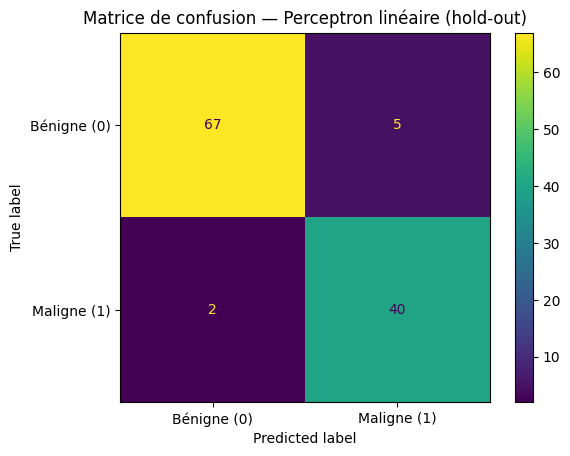


================= Perceptron linéaire — VALIDATION CROISÉE 5-fold =================

Accuracy (CV 5-fold)      : 0.9666
Taux d'erreur (CV 5-fold) : 0.0334

Rapport de classification (validation croisée) :
              precision    recall  f1-score   support

 Bénigne (0)       0.97      0.97      0.97       357
 Maligne (1)       0.96      0.95      0.96       212

    accuracy                           0.97       569
   macro avg       0.96      0.96      0.96       569
weighted avg       0.97      0.97      0.97       569

Matrice de confusion globale (CV) :
[[348   9]
 [ 10 202]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 348  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 9  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 10  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 202  -> tumeurs malignes correctement détectées

Résumé des 

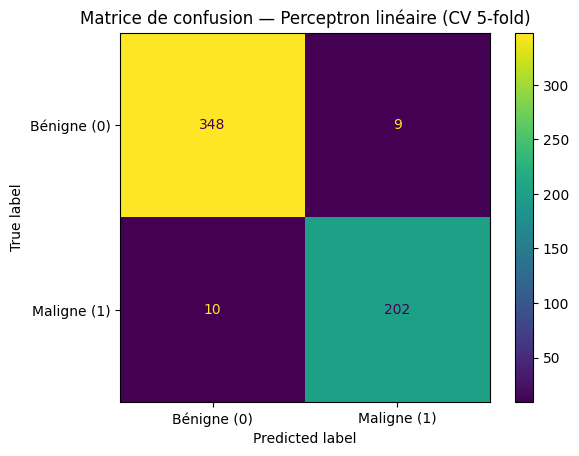

In [9]:
# Pipeline :
#   1) Standardisation des features (moyenne 0, variance 1)
#   2) Perceptron linéaire
pipe_perceptron = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", Perceptron(
        max_iter=1000,          # nombre max d'itérations (passes sur les données)
        tol=1e-3,               # critère d'arrêt sur la variation de l'erreur
        eta0=1.0,               # taux d'apprentissage initial
        # learning_rate="constant",
        random_state=0          # graine aléatoire (initialisation des poids)
    ))
])

# --- Évaluation hold-out ---
res_ph = eval_holdout(
    model=pipe_perceptron,
    model_name="Perceptron linéaire",
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test
)
resultats.append(res_ph)

# --- Évaluation validation croisée 5-fold ---
res_pcv = eval_cv(
    model=pipe_perceptron,
    model_name="Perceptron linéaire",
    X=X, y=y,
    cv_splits=5
)
resultats.append(res_pcv)

## Régression Logistqiue 


================= Régression logistique — Stratégie hold-out =================

Accuracy (test)      : 0.9737
Taux d'erreur (test) : 0.0263

Rapport de classification (test) :
              precision    recall  f1-score   support

 Bénigne (0)       0.97      0.99      0.98        72
 Maligne (1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Matrice de confusion (test) :
[[71  1]
 [ 2 40]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 71  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 1  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 2  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 40  -> tumeurs malignes correctement détectées

Résumé des erreurs :
  - Nombre total de faux positif

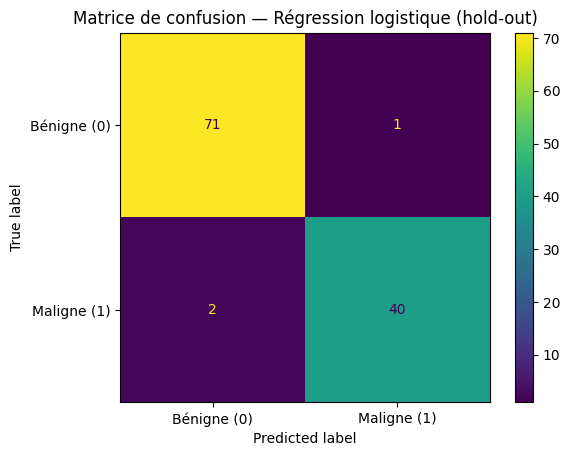


================= Régression logistique — VALIDATION CROISÉE 5-fold =================

Accuracy (CV 5-fold)      : 0.9789
Taux d'erreur (CV 5-fold) : 0.0211

Rapport de classification (validation croisée) :
              precision    recall  f1-score   support

 Bénigne (0)       0.98      0.99      0.98       357
 Maligne (1)       0.99      0.96      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.97      0.98       569
weighted avg       0.98      0.98      0.98       569

Matrice de confusion globale (CV) :
[[354   3]
 [  9 203]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 354  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 3  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 9  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 203  -> tumeurs malignes correctement détectées

Résumé des

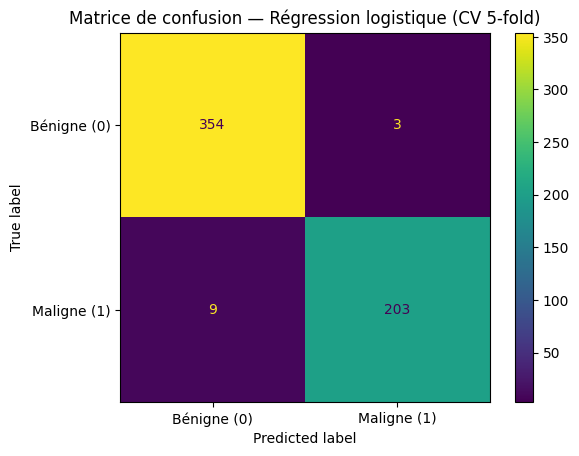

In [10]:
# Pipeline :
#   1) Standardisation
#   2) Régression logistique avec pénalité L2 (par défaut dans scikit-learn)
pipe_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",           # régularisation L2 
        C=1.0,                  # intensité de la régularisation (1/γ)
        solver="lbfgs",         # solveur adapté aux problèmes de taille moyenne
        max_iter=1000,          # nombre max d'itérations pour assurer la convergence
        random_state=0
    ))
])

# --- Évaluation hold-out ---
res_lh = eval_holdout(
    model=pipe_logreg,
    model_name="Régression logistique",
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test
)
resultats.append(res_lh)

# --- Évaluation validation croisée 5-fold ---
res_lcv = eval_cv(
    model=pipe_logreg,
    model_name="Régression logistique",
    X=X, y=y,
    cv_splits=5
)
resultats.append(res_lcv)

# SVM Linéaires


================= SVM linéaire — Stratégie hold-out =================

Accuracy (test)      : 0.9474
Taux d'erreur (test) : 0.0526

Rapport de classification (test) :
              precision    recall  f1-score   support

 Bénigne (0)       0.93      0.99      0.96        72
 Maligne (1)       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

Matrice de confusion (test) :
[[71  1]
 [ 5 37]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 71  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 1  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 5  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 37  -> tumeurs malignes correctement détectées

Résumé des erreurs :
  - Nombre total de faux positifs  : 1
  

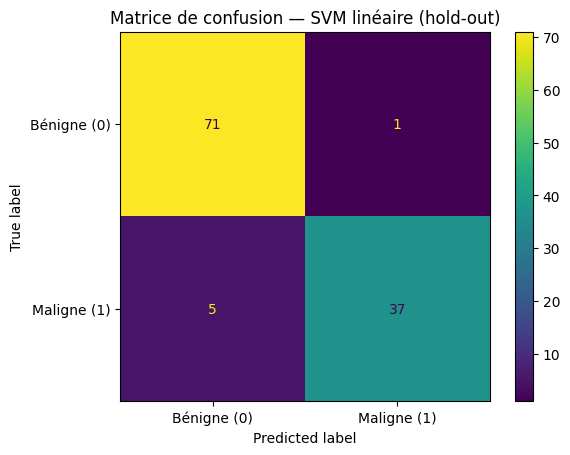


================= SVM linéaire — VALIDATION CROISÉE 5-fold =================

Accuracy (CV 5-fold)      : 0.9754
Taux d'erreur (CV 5-fold) : 0.0246

Rapport de classification (validation croisée) :
              precision    recall  f1-score   support

 Bénigne (0)       0.98      0.99      0.98       357
 Maligne (1)       0.98      0.96      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.97      0.97       569
weighted avg       0.98      0.98      0.98       569

Matrice de confusion globale (CV) :
[[352   5]
 [  9 203]]

Détail de la matrice de confusion (ordre des classes : [0, 1])
------------------------------------------------------------
Vrais négatifs  (TN) : 352  -> tumeurs bénignes correctement détectées
Faux positifs   (FP) : 5  -> tumeurs bénignes prédites malignes
Faux négatifs   (FN) : 9  -> tumeurs malignes prédites bénignes
Vrais positifs  (TP) : 203  -> tumeurs malignes correctement détectées

Résumé des erreurs 

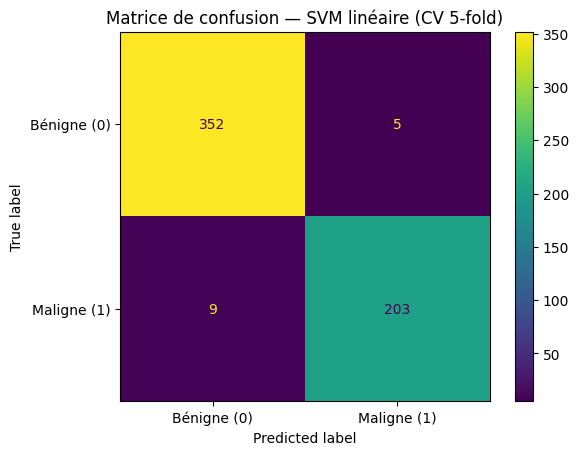

In [11]:
# Pipeline :
#   1) Standardisation
#   2) SVM linéaire (hyperplan à marge maximale, perte hinge)
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(
        C=1.0,                  # paramètre de régularisation (marge souple)
        loss="hinge",           # perte hinge classique des SVM
        max_iter=5000,          # nombre max d'itérations pour la convergence
        random_state=0
    ))
])

# --- Évaluation hold-out ---
res_sh = eval_holdout(
    model=pipe_svm,
    model_name="SVM linéaire",
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test
)
resultats.append(res_sh)

# --- Évaluation validation croisée 5-fold ---
res_scv = eval_cv(
    model=pipe_svm,
    model_name="SVM linéaire",
    X=X, y=y,
    cv_splits=5
)
resultats.append(res_scv)